## Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
!pip install -q tensorflow
!pip install -q bs4
!pip install -q lxml
!pip install -q gradio

In [2]:
# librerias necesarias
import os
import random
import io
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import bs4 as bs
import urllib.request

# fija seeds para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

### **1) Parámetros generales**

In [3]:
max_context_size = 100         # tamaño de la ventana (contexto)
p_val = 0.1                    # proporción para validación
batch_size = 256
max_epochs = 15
patience = 5                   # paciencia para el PplCallback
models_to_test = ["SimpleRNN", "LSTM", "GRU"]
rms_lr = 0.001                 # learning rate para RMSprop

### **2) Descargar y preprocesar corpus**

In [4]:
url = 'https://www.textos.info/julio-verne/viaje-al-centro-de-la-tierra/ebook'
print("Descargando texto desde:", url)
raw_html = urllib.request.urlopen(url).read()
article_html = bs.BeautifulSoup(raw_html, 'lxml')
article_paragraphs = article_html.find_all('p')

article_text = ''
for para in article_paragraphs:
    article_text += para.text + ' '

# preprocesamiento básico: minusculas y limpieza mínima
article_text = article_text.lower()

# remover saltos de línea extra, pero conservar espacios
article_text = article_text.replace('\r', ' ').replace('\n', ' ')
# reducir espacios múltiples
article_text = ' '.join(article_text.split())

print("Texto cargado. Longitud (caracteres):", len(article_text))
print("Muestra inicial del texto:\n", article_text[:1000])

Descargando texto desde: https://www.textos.info/julio-verne/viaje-al-centro-de-la-tierra/ebook
Texto cargado. Longitud (caracteres): 423888
Muestra inicial del texto:
 el domingo 24 de mayo de 1863, mi tío, el profesor lidenbrock, entró rápidamente a su hogar, situado en el número 19 de la könig‑strasse, una de las calles más tradicionales del barrio antiguo de hamburgo. marta, su excelente criada, se preocupó sobremanera, creyendo que se había retrasado, pues apenas empezaba a cocinar la comida en el hornillo. “bueno” —pensé para mí—, “si mi tío viene con hambre, se va a armar la de san quintín; porque no conozco a otro hombre de menos paciencia”. —¡tan temprano y ya está aquí el señor lidenbrock! —exclamó la pobre marta, con arrebol, entreabriendo la puerta del comedor. —sí, marta; pero tú no tienes la culpa de que la comida no esté lista todavía, porque es temprano, aún no son las dos. acaba de dar la media hora en san miguel. —¿y por qué ha venido tan pronto el señor lidenbrock? —

### **3) Tokenización por caracteres (vocabulario)**

In [5]:
chars_vocab = sorted(set(article_text))  # ordenado para consistencia
vocab_size = len(chars_vocab)
print("Tamaño vocab (caracteres únicos):", vocab_size)

char2idx = {k: v for v, k in enumerate(chars_vocab)}
idx2char = {v: k for k, v in char2idx.items()}

# tokenizamos todo el texto
tokenized_text = [char2idx[ch] for ch in article_text]

Tamaño vocab (caracteres únicos): 74


### **4) Construir dataset (ventanas) y split train/val**

In [6]:
num_val = int(np.ceil(len(tokenized_text) * p_val / max_context_size))
print("num_val (secuencias de validación):", num_val)

# separar porciones
train_text = tokenized_text[:-num_val * max_context_size]
val_text = tokenized_text[-num_val * max_context_size:]

# construir secuencias de longitud max_context_size (sliding window)
tokenized_sentences_train = [train_text[i:i + max_context_size] for i in range(len(train_text) - max_context_size + 1)]
tokenized_sentences_val = [val_text[i * max_context_size:(i + 1) * (max_context_size)] for i in range(num_val)]

# construir X, y (desplazadas una posición)
X = np.array(tokenized_sentences_train[:-1])   # cada entrada es una ventana completa
y = np.array(tokenized_sentences_train[1:])    # target: siguiente ventana (desfase 1)

print("X.shape (before reshape):", X.shape, " y.shape:", y.shape)
# reshape para tener dimensión de feature 1 por timestep (integers)
X = X.reshape((-1, max_context_size, 1))
# y: Keras espera enteros por timestep para sparse_categorical_crossentropy
y = y.reshape((-1, max_context_size, 1))

print("X.shape (final):", X.shape, " y.shape:", y.shape)
print("Ejemplo (primeros 10 tokens de X[0]):", X[0, :10, 0])
print("Ejemplo decode:", ''.join([idx2char[int(i)] for i in X[0, :50, 0]]))

num_val (secuencias de validación): 424
X.shape (before reshape): (381388, 100)  y.shape: (381388, 100)
X.shape (final): (381388, 100, 1)  y.shape: (381388, 100, 1)
Ejemplo (primeros 10 tokens de X[0]): [27 34  0 26 37 35 31 36 29 37]
Ejemplo decode: el domingo 24 de mayo de 1863, mi tío, el profesor


### **5) Callback de Perplejidad**

In [7]:
class PplCallback(keras.callbacks.Callback):
    """
    Calcula perplejidad en validación al final de cada epoch y realiza early stopping
    si no mejora durante `patience` epochs. Guarda el mejor modelo.
    """
    def __init__(self, val_data_sequences, max_context_size, char2idx_map, idx2char_map, history_ppl, patience=5, save_path_prefix="model"):
        super().__init__()
        self.val_data = val_data_sequences  # lista de secuencias (cada una longitud max_context_size)
        self.max_context_size = max_context_size
        self.history_ppl = history_ppl
        self.patience = patience
        self.min_score = np.inf
        self.patience_counter = 0
        self.save_path_prefix = save_path_prefix

        # preparar subsecuencias para evaluación:
        self.padded = []
        self.target = []
        self.info = []  # rangos para cada original seq
        count = 0
        for seq in self.val_data:
            # subseqs: seq[:i] para i=1..len-1 y targets seq[i]
            len_seq = len(seq)
            subseq = [seq[:i] for i in range(1, len_seq)]
            self.target.extend([seq[i] for i in range(1, len_seq)])
            if len(subseq) != 0:
                padded = pad_sequences(subseq, maxlen=self.max_context_size, padding='pre')
                self.padded.append(padded)
                self.info.append((count, count + len_seq - 1))
                count += len_seq - 1

        if len(self.padded) > 0:
            self.padded = np.vstack(self.padded)
            # reshape para que TimeDistributed(CategoryEncoding) reciba shape (..., timesteps, 1)
            self.padded = self.padded.reshape((-1, self.max_context_size, 1))
        else:
            self.padded = np.zeros((0, self.max_context_size, 1), dtype=int)
            self.info = []

    def on_epoch_end(self, epoch, logs=None):
        if self.padded.shape[0] == 0:
            print("No hay secuencias de validación para perplejidad.")
            return

        preds = self.model.predict(self.padded, verbose=0)
        # preds shape: (N, timesteps, vocab_size)
        scores = []
        # transformar target a lista de ints
        targets = self.target
        for start, end in self.info:
            probs = [preds[idx_seq, -1, idx_vocab] for idx_seq, idx_vocab in zip(range(start, end), targets[start:end])]
            # evitar ceros
            probs = np.clip(probs, 1e-12, 1.0)
            ppl = np.exp(-np.sum(np.log(probs)) / len(probs))
            scores.append(ppl)
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f"\n mean perplexity: {current_score} \n")
        # early stopping & save best
        if current_score < self.min_score:
            self.min_score = current_score
            # save model with prefix + epoch
            save_name = f"{self.save_path_prefix}_best.keras"
            self.model.save(save_name)
            print("Se guardó el nuevo modelo en", save_name)
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                print("Se detiene el entrenamiento (se alcanzó el límite de paciencia de PplCallback).")
                self.model.stop_training = True


### **6) Función para construir modelo recurrente**

In [8]:
def build_model(arch="LSTM", vocab_size=vocab_size, rnn_units=200, input_shape=(None,1), dropout=0.1, recurrent_dropout=0.1, use_embedding=False, embedding_dim=64):
    """
    arch: "SimpleRNN", "LSTM", "GRU"
    """
    model = Sequential()

    # One-hot via CategoryEncoding rodeado por TimeDistributed
    # CategoryEncoding requiere timesteps x 1 integer input
    model.add(TimeDistributed(layers.CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"),
                                  input_shape=input_shape))

    # agregar la celda recurrente según arch
    if arch == "SimpleRNN":
        model.add(SimpleRNN(rnn_units, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
    elif arch == "LSTM":
        model.add(LSTM(rnn_units, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
    elif arch == "GRU":
        model.add(GRU(rnn_units, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
    else:
        raise ValueError("arch must be one of SimpleRNN/LSTM/GRU")

    model.add(Dense(vocab_size, activation="softmax"))
    opt = RMSprop(learning_rate=rms_lr)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)
    return model

### **7) Entrenamiento**

In [9]:
results = {}
histories = {}

# convert val sequences to list of lists (integers)
val_sequences_for_callback = [list(seq) for seq in tokenized_sentences_val]

for arch in models_to_test:
    print("\n\n==============================================")
    print("Entrenando arquitectura:", arch)
    print("==============================================\n")

    history_ppl = []
    # prefijo de guardado único por arquitectura
    save_prefix = f"model_{arch}"
    callback = PplCallback(val_sequences_for_callback, max_context_size, char2idx, idx2char, history_ppl, patience=patience, save_path_prefix=save_prefix)

    # probar con one-hot
    model = build_model(arch=arch, use_embedding=False, rnn_units=200, input_shape=(max_context_size,1))
    model.summary()

    # fit (X,y) -- X shape: (N, timesteps,1), y shape: (N, timesteps,1)
    st = time.time()
    hist = model.fit(X, y, epochs=max_epochs, callbacks=[callback], batch_size=batch_size, verbose=1)
    et = time.time()
    elapsed = et - st
    print(f"Tiempo de entrenamiento ({arch}): {elapsed/60:.2f} minutos")

    # almacenar métricas
    results[arch] = {
        "best_val_ppl": callback.min_score,
        "history_ppl": history_ppl,
        "training_time_min": elapsed/60
    }
    histories[arch] = hist

    print(f"Fin entrenamiento {arch}. Mejor perplejidad encontrada: {callback.min_score}")




Entrenando arquitectura: SimpleRNN



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 100, 74)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 100, 200)       │        55,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100, 74)        │        14,874 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,874 (272.95 KB)

 Trainable params: 69,874 (272.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.4355
 mean perplexity: 6.449993133544922 

Se guardó el nuevo modelo en model_SimpleRNN_best.keras
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - loss: 2.4353
Epoch 2/15
1488/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9421
 mean perplexity: 5.56279182434082 

Se guardó el nuevo modelo en model_SimpleRNN_best.keras
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - loss: 1.9420
Epoch 3/15
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8393
 mean perplexity: 5.142533302307129 

Se guardó el nuevo modelo en model_SimpleRNN_best.keras
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - loss: 1.8393
Epoch 4/15
1488/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7923
 mean perplexity: 5.00040340423584 

Se guardó el nuevo modelo en model_SimpleRNN_best.keras
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - loss: 1.7923
Epoch 5/15
1488/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7653
 mean perplexity: 4.899244785308838 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, 100, 74)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 200)       │       220,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100, 74)        │        14,874 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,874 (917.48 KB)

 Trainable params: 234,874 (917.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 2.6533
 mean perplexity: 8.210362434387207 

Se guardó el nuevo modelo en model_LSTM_best.keras
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 484s 319ms/step - loss: 2.6532
Epoch 2/15
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 2.1127
 mean perplexity: 7.208709716796875 

Se guardó el nuevo modelo en model_LSTM_best.keras
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 470s 316ms/step - loss: 2.1127
Epoch 3/15
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 2.0006
 mean perplexity: 6.591031074523926 

Se guardó el nuevo modelo en model_LSTM_best.keras
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 465s 312ms/step - loss: 2.0006
Epoch 4/15
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 1.9203
 mean perplexity: 6.10617733001709 

Se guardó el nuevo modelo en model_LSTM_best.keras
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 467s 313ms/step - loss: 1.9202
Epoch 5/15
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 1.8552
 mean perplexity: 5.7534356117248535 

Se 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, 100, 74)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100, 200)       │       165,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100, 74)        │        14,874 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180,474 (704.98 KB)

 Trainable params: 180,474 (704.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 2.4930
 mean perplexity: 6.6995062828063965 

Se guardó el nuevo modelo en model_GRU_best.keras
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 504s 335ms/step - loss: 2.4928
Epoch 2/15
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 1.8941
 mean perplexity: 5.270864963531494 

Se guardó el nuevo modelo en model_GRU_best.keras
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 443s 297ms/step - loss: 1.8940
Epoch 3/15
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 1.6938
 mean perplexity: 4.774665832519531 

Se guardó el nuevo modelo en model_GRU_best.keras
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 444s 298ms/step - loss: 1.6937
Epoch 4/15
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 1.5882
 mean perplexity: 4.493988037109375 

Se guardó el nuevo modelo en model_GRU_best.keras
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 442s 296ms/step - loss: 1.5882
Epoch 5/15
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 1.5263
 mean perplexity: 4.361446380615234 

Se gua

### **8) Seleccionar mejor modelo (menor perplejidad)**

In [10]:
best_arch = None
best_ppl = np.inf
for arch, info in results.items():
    ppl = info["best_val_ppl"]
    print(f"{arch} -> best_val_ppl: {ppl}")
    if ppl < best_ppl:
        best_ppl = ppl
        best_arch = arch

print("\nMejor arquitectura según perplejidad:", best_arch, "con PPL =", best_ppl)
best_model_path = f"model_{best_arch}_best.keras"
print("Mejor modelo guardado en:", best_model_path)

# cargar el mejor modelo
best_model = keras.models.load_model(best_model_path)

# guardar copia final
final_save_path = "best_model_final.keras"
best_model.save(final_save_path)
print("Copia final guardada en:", final_save_path)

SimpleRNN -> best_val_ppl: 4.564990997314453
LSTM -> best_val_ppl: 4.520737648010254
GRU -> best_val_ppl: 4.053084850311279

Mejor arquitectura según perplejidad: GRU con PPL = 4.053085
Mejor modelo guardado en: model_GRU_best.keras
Copia final guardada en: best_model_final.keras


### **9) Funciones de generación**

In [11]:
def greedy_generate(model, seed_text, n_chars=200, max_length=max_context_size):
    output_text = seed_text
    for _ in range(n_chars):
        encoded = [char2idx.get(ch, 0) for ch in output_text.lower()]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
        encoded = encoded.reshape((1, max_length, 1))
        preds = model.predict(encoded, verbose=0)[0, -1, :]
        next_idx = np.argmax(preds)
        output_text += idx2char[next_idx]
    return output_text

def sample_from_probs(probs, temperature=1.0):
    preds = np.asarray(probs).astype('float64')
    preds = np.log(preds + 1e-12) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Beam Search (determinístico / estocástico)
from scipy.special import softmax

def beam_search(model, input_text, num_beams=5, num_words=20, temp=1.0, mode='det'):
    """
    mode: 'det' (deterministic beam) or 'sto' (stochastic beam with temperature)
    Returns: decoded sequence (string) for best beam (or first)
    """
    # codificar entrada
    encoded = [char2idx.get(ch, 0) for ch in input_text.lower()]
    encoded_padded = pad_sequences([encoded], maxlen=max_context_size, padding='pre').reshape(1, max_context_size, 1)

    # predicción inicial
    y_hat = model.predict(encoded_padded, verbose=0)[0, -1, :]
    vocab_s = y_hat.shape[0]
    # historial: guardar probabilidades y secuencias
    history_log = [0.0] * num_beams
    history_tokens = [encoded_padded[0].copy() for _ in range(num_beams)]  # each is (max_length,1)

    # Primera selección: ampliar por vocabulario -> elegir las mejores opciones
    if mode == 'det':
        idxs = np.argsort(np.log(y_hat + 1e-12))[::-1][:num_beams]
    else:
        # Estocástico: muestrear con temperatura a partir de la distribución del vocabulario
        probs = softmax(np.log(y_hat + 1e-12) / temp)
        idxs = np.random.choice(np.arange(vocab_s), size=num_beams, replace=False, p=probs)

    new_history_log = []
    new_history_tokens = []
    for i,k in enumerate(idxs):
        new_history_log.append(np.log(y_hat[k] + 1e-12))
        seq = history_tokens[0].copy()
        # append new token at end (shift sliding window to include it)
        seq = np.concatenate([seq[1:], np.array([[k]])], axis=0)
        new_history_tokens.append(seq)
    history_log = new_history_log
    history_tokens = new_history_tokens

    # iterative expansion
    for _ in range(num_words-1):
        # for each beam, predict next distribution
        preds_list = []
        for seq in history_tokens:
            input_seq = np.array([seq])  # shape (1, max_length, 1)
            y_hat = model.predict(input_seq, verbose=0)[0, -1, :]
            preds_list.append(y_hat)

        # build candidate pool (beam_size * vocab) with log-probs
        all_candidates = []
        for b_idx, pred in enumerate(preds_list):
            for tok_idx in range(vocab_s):
                lp = history_log[b_idx] + np.log(pred[tok_idx] + 1e-12)
                all_candidates.append((lp, b_idx, tok_idx))

        # política de selección
        all_candidates.sort(key=lambda x: x[0], reverse=True)
        if mode == 'det':
            selected = all_candidates[:num_beams]
        else:  # Selección estocástica basada en la temperatura aplicada a los logits
            logits = np.array([cand[0] for cand in all_candidates])
            # Normalizar y muestrear índices únicos (num_beams)
            probs = softmax(logits / max(1e-6, temp))
            selected_indices = np.random.choice(len(all_candidates), size=num_beams, replace=False, p=probs)
            selected = [all_candidates[i] for i in selected_indices]

        # Actualizar tokens y registros del historial
        new_history_log = []
        new_history_tokens = []
        for lp, from_beam, tok in selected:
            base_seq = history_tokens[from_beam]
            new_seq = np.concatenate([base_seq[1:], np.array([[tok]])], axis=0)
            new_history_log.append(lp)
            new_history_tokens.append(new_seq)
        history_log = new_history_log
        history_tokens = new_history_tokens

    # Seleccionar el mejor resultado (mayor probabilidad logarítmica)
    best_idx = int(np.argmax(history_log))
    best_seq = history_tokens[best_idx]  # shape (max_length,1)
    # decode last (len(input)+num_words) tokens for readability
    # we return the decoded string of the last part
    decoded = ''.join([idx2char[int(i[0])] for i in best_seq])
    return decoded


### **10) Pruebas de generación con el mejor modelo**

In [12]:
seed = "habia una vez"
print("\n--- Greedy generation (best model) ---")
print(greedy_generate(best_model, seed, n_chars=120))

print("\n--- Beam search deterministic (k=5) ---")
print(beam_search(best_model, seed, num_beams=5, num_words=80, temp=1.0, mode='det'))

print("\n--- Beam search stochastic (k=5, temp=0.7) ---")
print(beam_search(best_model, seed, num_beams=5, num_words=80, temp=0.7, mode='sto'))

print("\n--- Beam search stochastic (k=5, temp=1.2) ---")
print(beam_search(best_model, seed, num_beams=5, num_words=80, temp=1.2, mode='sto'))



--- Greedy generation (best model) ---
habia una vez que esta cabeza con la mano de la cabeza de la cabeza de la cabeza de la cabeza de la cabeza de la cabeza de la cabeza 

--- Beam search deterministic (k=5) ---
       habia una vez que nos hallábamos en el camino de la corteza terrestre, porque no habíamos de 

--- Beam search stochastic (k=5, temp=0.7) ---
       habia una vez que habíamos de una parte de la tierra, y después de una especie de mi tío, y e

--- Beam search stochastic (k=5, temp=1.2) ---
       habia una vez que nos había en la temperatura de la tierra de la palabra, con un cráter del g


### **11) Guardar artefactos (tokenizers/dicts y resultados)**

In [13]:
with open("char2idx.pkl", "wb") as f:
    pickle.dump(char2idx, f)
with open("idx2char.pkl", "wb") as f:
    pickle.dump(idx2char, f)
with open("training_results.pkl", "wb") as f:
    pickle.dump(results, f)

print("Guardado: char2idx.pkl, idx2char.pkl, training_results.pkl, best_model_final.keras")


Guardado: char2idx.pkl, idx2char.pkl, training_results.pkl, best_model_final.keras


### **12) Graficas de perplejidad por arquitectura**

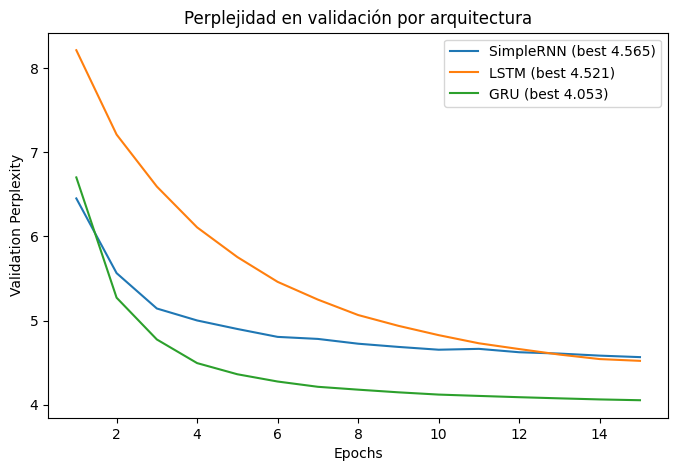

In [14]:
plt.figure(figsize=(8,5))
for arch, info in results.items():
    hist_ppl = info['history_ppl']
    if len(hist_ppl) > 0:
        plt.plot(range(1, len(hist_ppl)+1), hist_ppl, label=f"{arch} (best {info['best_val_ppl']:.3f})")
plt.xlabel("Epochs")
plt.ylabel("Validation Perplexity")
plt.legend()
plt.title("Perplejidad en validación por arquitectura")
plt.show()

### **13) Pruebas con gradio**



In [ ]:
#Descomentar en caso de solo ejecutar esta ultima celda para probar el modelo
#!pip install -q gradio
import gradio as gr
import pickle, glob
#import numpy as np
#from tensorflow import keras
#from tensorflow.keras.utils import pad_sequences

# Cargar diccionarios
with open("char2idx.pkl", "rb") as f:
    char2idx = pickle.load(f)
with open("idx2char.pkl", "rb") as f:
    idx2char = pickle.load(f)

max_context_size = 100

# Función auxiliar para muestreo con temperatura
def sample_from_probs(probs, temperature=1.0):
    preds = np.asarray(probs).astype("float64")
    preds = np.log(preds + 1e-12) / (temperature if temperature > 0 else 1e-6)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.argmax(np.random.multinomial(1, preds, 1))

# Funciones de generación
def greedy_generate(model, seed, n_chars=200):
    text = seed
    for _ in range(n_chars):
        encoded = [char2idx.get(ch, 0) for ch in text.lower()]
        encoded = pad_sequences([encoded], maxlen=max_context_size, padding="pre").reshape(1, max_context_size, 1)
        preds = model.predict(encoded, verbose=0)[0, -1, :]
        next_idx = np.argmax(preds)
        text += idx2char[next_idx]
    return text

def beam_search(model, seed, num_beams=3, num_words=100, temp=1.0, mode="det"):
    sequences = [(seed, 0.0)]
    for _ in range(num_words):
        all_candidates = []
        for seq, score in sequences:
            encoded = [char2idx.get(ch, 0) for ch in seq.lower()]
            encoded = pad_sequences([encoded], maxlen=max_context_size, padding="pre").reshape(1, max_context_size, 1)
            preds = model.predict(encoded, verbose=0)[0, -1, :]
            if mode == "det":
                top_indices = np.argsort(preds)[-num_beams:]
            else:
                top_indices = np.random.choice(len(preds), num_beams, p=preds/np.sum(preds))
            for idx in top_indices:
                candidate = (seq + idx2char[idx], score - np.log(preds[idx] + 1e-12))
                all_candidates.append(candidate)
        sequences = sorted(all_candidates, key=lambda tup: tup[1])[:num_beams]
    return sequences[0][0]

# Buscar modelos guardados en el directorio
model_files = sorted(glob.glob("*.keras"))
if not model_files:
    raise RuntimeError("No se encontraron archivos .keras en el directorio actual.")

_loaded_models = {}
def load_model_cached(path):
    if path in _loaded_models:
        return _loaded_models[path]
    _loaded_models[path] = keras.models.load_model(path)
    return _loaded_models[path]

# Wrapper para Gradio
def gradio_wrapper(seed, n_chars, temperature, method, beam_size, model_file):
    model = load_model_cached(model_file)
    seed = str(seed) if seed else ""
    if method == "next_char":
        encoded = [char2idx.get(ch, 0) for ch in seed.lower()]
        encoded = pad_sequences([encoded], maxlen=max_context_size, padding="pre").reshape(1, max_context_size, 1)
        preds = model.predict(encoded, verbose=0)[0, -1, :]
        next_idx = sample_from_probs(preds, temperature)
        return seed + idx2char[next_idx]
    elif method == "greedy":
        return greedy_generate(model, seed, n_chars=n_chars)
    elif method == "beam_det":
        return beam_search(model, seed, num_beams=beam_size, num_words=n_chars, temp=temperature, mode="det")
    elif method == "beam_sto":
        return beam_search(model, seed, num_beams=beam_size, num_words=n_chars, temp=temperature, mode="sto")
    return "Método no reconocido."

# Interfaz Gradio
iface = gr.Interface(
    fn=gradio_wrapper,
    inputs=[
        gr.Textbox(label="Seed (texto inicial)", placeholder="Ej: habia una vez"),
        gr.Slider(1, 100, step=1, value=100, label="n_chars"),
        gr.Slider(0, 2.0, step=0.1, value=1.0, label="Temperatura"),
        gr.Dropdown(["next_char", "greedy", "beam_det", "beam_sto"], value="greedy", label="Método"),
        gr.Slider(0, 10, step=1, value=3, label="Beam size"),
        gr.Dropdown(model_files, value=model_files[0], label="Modelo a usar (.keras)")
    ],
    outputs="text",
    title="Generador de texto con modelos guardados",
    description="Selecciona el modelo entrenado y prueba la generación de texto con diferentes estrategias."
)

iface.launch(share=False)


/home/jv/anaconda3/envs/Procesamiento_lenguaje_natural/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-01 22:25:34.801422: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-01 22:25:35.594833: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-01 22:25:40.028887: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


### Resumen y analisis de los resultados:
1. Se selecciono el libro "Viaje al Centro de la Tierra de Julio Verne" (423k caracteres) como el corpus de texto sobre el cual se entreno el modelo de lenguaje.

2. Se aplico un pre-procesamiento adecuado: tokenización por caracteres, estructuracion del dataset, split en train/val.

3. Se probaron 3 arquitecturas con unidades recurrentes (SimpleRNN, LSTM, GRU).

- Todas las arquitecturas redujeron perplejidad de forma consistente, sin sobreajuste notable en solo 15 épocas.

    - SimpleRNN → desempeño aceptable pero limitado.

    - LSTM → más robusto, pero más lento en convergencia.

    - GRU → mejor balance: menos parámetros que LSTM, menor tiempo y mejor perplejidad final.

- Evaluación con perplejidad.

    - SimpleRNN: mejor PPL ≈ 4.56

    - LSTM: mejor PPL ≈ 4.52

    - GRU: mejor PPL ≈ 4.05 → mejor arquitectura

4. Se generaron nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico.

- Se utilizo la interfaz interactiva con gradio para probar el mejor modelo entrenado:

    - Predecir el proximo caracter (seleccionar como metodo next_char y temperatura 0.2 en la interfaz de gradio):
         
         Se pudo comprobar que el modelo hace la prediccion del siguiente caracter de forma correcta, por ejemplo: se le paso como texto "tierr" y predijo el siguiente caracter, dando como resultado la palabra "tierra".

- Generacion de nuevas secuencias a partir de un texto inicial (probar la interfaz con gradio)

    - Utilizando la estrategia Greedy (seleccionar como metodo greedy sin beam size ni temperatura):
        
        Las secuencia de texto que se generan terminan siendo deterministas, tiende a repetir ciertos tokens.
        
        Ejemplo: 
        
        - texto inicial: "habia una vez"
                 
        - texto final:   "habia una vez que esta cabeza con la mano de la cabeza de la cabeza de la cabeza de la cabeza de la cabeza de la" 

    - Utilizando la estrategia Beam search determinístico (seleccionar como metodo beam_det con beam size de 5 y sin temperatura, para obtener mejores resultados): 
        
        Las secuencias de texto que genera son mas coherentes pero algo redundantes.
        
        Ejemplo: 
        
        - texto inicial: "habia una vez"
                 
        - texto final:   "habia una vez que nos encontrábamos en el camino de la corteza terrestre, porque no habíamos llegado a la superfie"

    - Utilizando la estrategia Beam search estocástico + temperatura (seleccionar como metodo beam_sto con beam size 5 y temperatura de 0.8, variar la temperatura para ver distintos resultados): 
        
        La secuencias de texto que genera presentan cierta variación y creatividad segun la temperatura que se aplique, aunque pierde coherencia con temperaturas altas.
        
        Ejemplo: 
        
        - texto inicial: "habia una vez"
        
        - texto final:   "habia una vez que no había descendido a la superficie de la tierra de la tierra de la tierra de la cabeza de la c"

